#Model comparison and validation for Northern Italy.

###Import Python and Obspy modules

In [56]:
# To keep the figure inside the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import sys

from obspy import Stream, UTCDateTime
from obspy.core import read
from obspy.core.util import locations2degrees
from obspy.taup import TauPyModel
from obspy.imaging.beachball import Beachball

###Path specification for real and synthetic data

In [30]:
# real data and synthetic paths
# ATTENTION: the data headers should be set!
data_path = './data_Emilia_earthquake'
syn_path = './syn_Emilia_earthquake'

###Stations IDs
#####In this example, we choose two stations: one on rock and the other on sedimentary basin. The goal is to compare the behavior of these stations by doing different measurements on the results.

In [90]:
# You can use * for all stations or specify them in a list as follow:
# Default:
# data_ids = ['IV_BDI_Z.sac', 'IV_TEOL_Z.sac']
# syn_spec3_ids = ['BDI.IV.HXZ.semd.sac', 'VLC.MN.HXZ.semd.sac']

data_ids = ['IV_BDI_Z.sac', 'IV_TEOL_Z.sac', 'IV_TEOL_Z.sac']
syn_ids = ['BDI.IV.HXZ.semd.sac', 'VLC.MN.HXZ.semd.sac', 'VLC.MN.HXZ.semd.sac']

###Read event information

#####Event information is in "CMTSOLUTION" format as follow:

<img src="./figs/event_info.png">

In [91]:
ev_info_path = './events/INGV_2012_05_29__Mw_5_6'
ev_info_dict = {}
with open(ev_info_path) as ev_info:
    ev_ls = ev_info.readlines()
    line1 = ev_ls[0].split()
    ev_info_dict['time'] = UTCDateTime("%s-%s-%sT%s:%s:%s" % (line1[1], line1[2], line1[3], 
                                                              line1[4], line1[5], line1[6]))
    ev_info_dict['lat'] = float(ev_ls[4].split(':')[1])
    ev_info_dict['lon'] = float(ev_ls[5].split(':')[1])
    ev_info_dict['depth'] = float(ev_ls[6].split(':')[1])
    ev_info_dict['mrr'] = float(ev_ls[7].split(':')[1])
    ev_info_dict['mtt'] = float(ev_ls[8].split(':')[1])
    ev_info_dict['mpp'] = float(ev_ls[9].split(':')[1])
    ev_info_dict['mrt'] = float(ev_ls[10].split(':')[1])
    ev_info_dict['mrp'] = float(ev_ls[11].split(':')[1])
    ev_info_dict['mtp'] = float(ev_ls[12].split(':')[1])

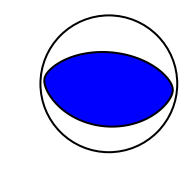

In [92]:
# Graphical representation of the focal mechanism:
focmecs = [ev_info_dict['mrr'], ev_info_dict['mtt'], ev_info_dict['mpp'], 
           ev_info_dict['mrt'], ev_info_dict['mrp'], ev_info_dict['mtp']]
Beachball(focmecs, size=200, linewidth=2, facecolor='b')
plt.show()

###Read station information

In [93]:
sta_info_path = './stations/STATIONS_Bertinoro'
sta_info_dict = {}
with open(sta_info_path) as sta_info:
    sta_ls = sta_info.readlines()
    for sta_line in sta_ls:
        sta_line = sta_line.split()
        sta_id = '%s.%s' % (sta_line[1], sta_line[0])
        # sta_info_dict has the following items: [lat, lon, elevation, depth]
        sta_info_dict[sta_id] = [float(sta_line[2]), float(sta_line[3]), 
                                 float(sta_line[4]), float(sta_line[5])]

###Read real and synthetic waveforms

In [94]:
# Define empty streams and append the traces in the next step.
real_wfs = Stream()
syn_wfs = Stream()
for data_id in data_ids:
    real_wfs.append(read(os.path.join(data_path, data_id))[0])
for syn_id in syn_ids:
    syn_wfs.append(read(os.path.join(syn_path, syn_id))[0])
# make sure that the number of real and synthetic waveforms is the same
if len(real_wfs) != len(syn_wfs):
    raise Exception('Number of real (%i) and synthetic (%i) waveforms is not the same!' % (len(real_data), len(syn_data)))
print real_wfs
print syn_wfs

3 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T06:55:39.845000Z - 2012-05-29T08:30:13.145000Z | 20.0 Hz, 113467 samples
IV.TEOL..BHZ | 2012-05-29T06:55:39.195000Z - 2012-05-29T08:30:12.595000Z | 20.0 Hz, 113469 samples
IV.TEOL..BHZ | 2012-05-29T06:55:39.195000Z - 2012-05-29T08:30:12.595000Z | 20.0 Hz, 113469 samples
3 Trace(s) in Stream:
IV.BDI..BHZ  | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.944886Z | 200.0 Hz, 100000 samples
IV.TEOL..BHZ | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.944886Z | 200.0 Hz, 100000 samples
IV.TEOL..BHZ | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.944886Z | 200.0 Hz, 100000 samples


###Preparing synthetic waveforms

In [95]:
# resample both synthetic and real waveforms
min_sampling = real_wfs[0].stats.sampling_rate
for real_wf in real_wfs:
    min_sampling = min(min_sampling, real_wf.stats.sampling_rate)
# collect starttime of the synthetic for the next step
syn_initial_starttime = []
for syn_wf in syn_wfs:
    min_sampling = min(min_sampling, syn_wf.stats.sampling_rate)
    syn_initial_starttime.append(syn_wf.stats.starttime)
# resample
real_wfs.resample(min_sampling)
syn_wfs.resample(min_sampling)

3 Trace(s) in Stream:
IV.BDI..BHZ  | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.850000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.850000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.850000Z | 20.0 Hz, 9999 samples

###Set starttime of the synthetics and slice both synthetic and real data

In [96]:
for i, syn_wf in enumerate(syn_wfs):
    syn_starttime = ev_info_dict['time'] + (UTCDateTime(0) - syn_initial_starttime[i])
    syn_wf.stats.starttime = syn_starttime

slice_starttime = syn_wfs[0].stats.starttime
slice_endtime = syn_wfs[0].stats.endtime
for i in range(len(real_wfs)):
    slice_starttime = max(slice_starttime, real_wfs[i].stats.starttime, syn_wfs[i].stats.starttime)
    slice_endtime = min(slice_endtime, real_wfs[i].stats.endtime, syn_wfs[i].stats.endtime)
    
real_wfs = real_wfs.slice(starttime=slice_starttime, endtime=slice_endtime)
syn_wfs = syn_wfs.slice(starttime=slice_starttime, endtime=slice_endtime) 

###Process the data here

In [97]:
# Make a copy of the resampled data (this avoids running the above cells)
real_wfs_cp = real_wfs.copy()
syn_wfs_cp = syn_wfs.copy()

real_wfs_cp.detrend("linear")
real_wfs_cp.taper(max_percentage=0.05, type="hann")
real_wfs_cp.filter("bandpass", freqmin=1.0 / 25.0, freqmax=1.0 / 3.0, zerophase=True)

syn_wfs_cp.detrend("linear")
syn_wfs_cp.taper(max_percentage=0.05, type="hann")
syn_wfs_cp.filter("bandpass", freqmin=1.0 / 25.0, freqmax=1.0 / 3.0, zerophase=True)

3 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples

###Plot the waveforms

In [126]:
def plot_real_syn(real_wfs, syn_wfs, plt_xlim=False, cal_arrivals=False):
    """
    Function to plot real and synthetic waveforms
    """
    model = TauPyModel(model="iasp91")
    plt.figure(figsize=(len(real_wfs)*7, 10))
    for i, real_wf in enumerate(real_wfs):
        sta_info = sta_info_dict['%s.%s' % (real_wf.stats.network, real_wf.stats.station)]
        dist = locations2degrees(ev_info_dict['lat'], ev_info_dict['lon'], sta_info[0], sta_info[1])
        
        if cal_arrivals:
            arrivals = model.get_travel_times(source_depth_in_km=ev_info_dict['depth'], distance_in_degree=dist)

        plt.subplot(len(real_wfs)*2, 2, 2*i+1)
        tax_real = np.linspace(0, (real_wf.stats.npts - 1)/real_wf.stats.sampling_rate, real_wf.stats.npts)
        plt.plot(tax_real, real_wf.data/max(abs(real_wf.data)), c='k', label='real')

        time_difference = syn_wfs[i].stats.starttime - real_wf.stats.starttime
        tax_syn = time_difference + np.linspace(0, (syn_wfs[i].stats.npts - 1)/syn_wfs[i].stats.sampling_rate, syn_wfs[i].stats.npts)
        plt.plot(tax_syn, syn_wfs[i].data/max(abs(syn_wfs[i].data)), c='r', label='synthetic')

        if i == (len(real_wfs) - 1):
            plt.xlabel('Time', size=18, weight='bold')
        if i == 0:
            plt.ylabel('Normalized amplitude', size=18, weight='bold')
        plt.title('%s.%s' % (real_wf.stats.network, real_wf.stats.station))
        
        if cal_arrivals:
            for arr in arrivals:
                if not arr.time > tax_syn[-1]:
                    plt.axvline(arr.time, 0, 1, 'k')
        if plt_xlim:
            plt.xlim(0, plt_xlim)

        plt.subplot(len(real_wfs)*2, 2, 2*i+2)
        tax_real = np.linspace(0, (real_wf.stats.npts - 1)/real_wf.stats.sampling_rate, real_wf.stats.npts)
        plt.plot(tax_real, real_wf.data/1.e9, c='k', label='real')

        time_difference = syn_wfs[i].stats.starttime - real_wf.stats.starttime
        tax_syn = time_difference + np.linspace(0, (syn_wfs[i].stats.npts - 1)/syn_wfs[i].stats.sampling_rate, syn_wfs[i].stats.npts)
        plt.plot(tax_syn, syn_wfs[i].data, c='r', label='synthetic')
        if i == (len(real_wfs) - 1):
            plt.xlabel('Time', size=18, weight='bold')
        if i == 0:
            plt.ylabel('Amplitude', size=18, weight='bold')
        plt.title('%s.%s' % (real_wf.stats.network, real_wf.stats.station))

        if cal_arrivals:
            print "list of phases: (station: %s.%s, dist: %s)" % (real_wf.stats.network, real_wf.stats.station, dist)
            for arr in arrivals:
                if not arr.time > tax_syn[-1]:
                    plt.axvline(arr.time, 0, 1, 'k')
                    print '%s' % (arr.name),
            print "\n"
        if plt_xlim:
            plt.xlim(0, plt_xlim)
            
        plt.legend()

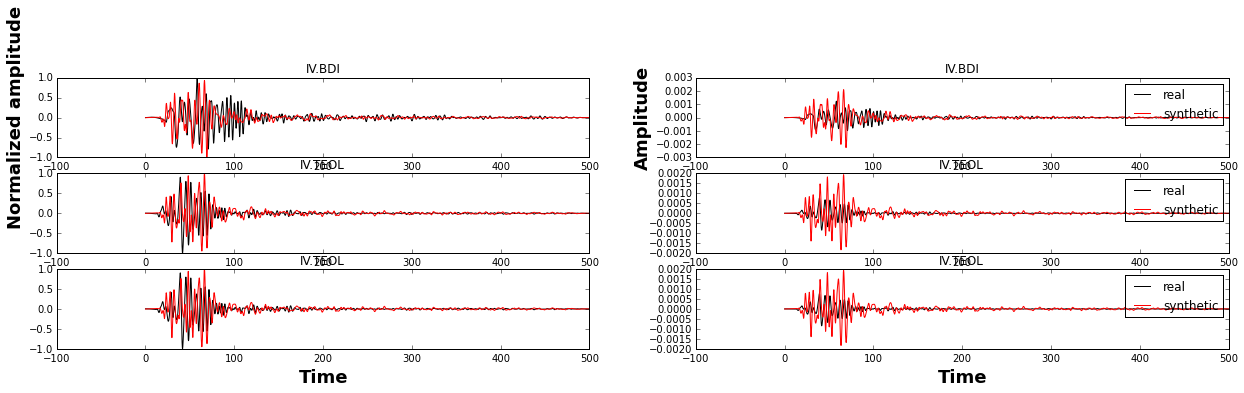

In [127]:
plot_real_syn(real_wfs=real_wfs_cp, syn_wfs=syn_wfs_cp)

list of phases: (station: IV.BDI, dist: 0.848105458673)
p P P P Pn sP P sP sP pP pP sP sP s S S S Sn S 

list of phases: (station: IV.TEOL, dist: 0.674278310031)
p P P sP P Pn P s S S 

list of phases: (station: IV.TEOL, dist: 0.674278310031)
p P P sP P Pn P s S S 



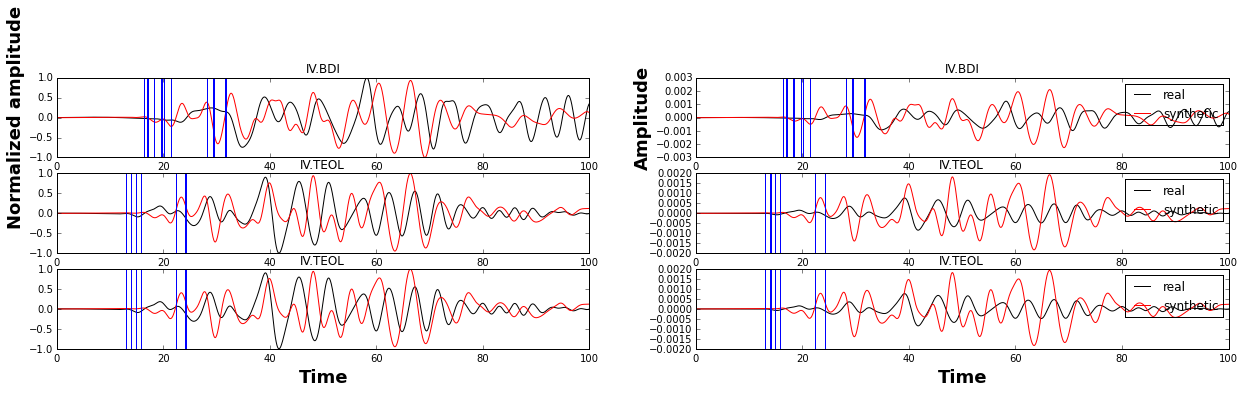

In [128]:
plot_real_syn(real_wfs=real_wfs_cp, syn_wfs=syn_wfs_cp, plt_xlim=100, cal_arrivals=True)

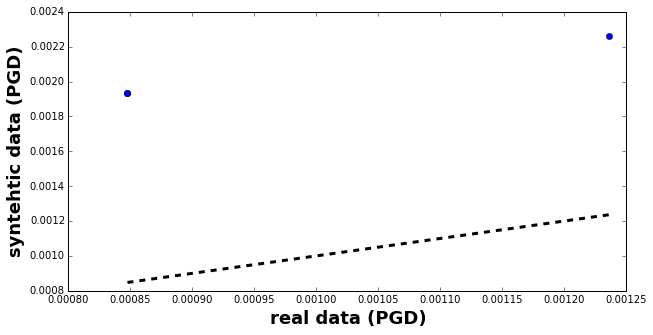

In [150]:
# Calculate PGD and scatter plot
pgd_syn = syn_wfs_cp.max()
pgd_real = real_wfs_cp.max()

plt.figure(figsize=(10, 5))
plt.plot(np.abs(pgd_real)/1.e9, np.abs(pgd_syn), 'o')
plt.plot([min(np.abs(pgd_real))/1.e9, max(np.abs(pgd_real))/1.e9], 
         [min(np.abs(pgd_real))/1.e9, max(np.abs(pgd_real))/1.e9], 
         'k--', lw=3)
plt.xlabel('real data (PGD)', size=18, weight='bold')
plt.ylabel('syntehtic data (PGD)', size=18, weight='bold')

In [13]:
#################### TRASH #########################


import pyflex

config = pyflex.Config(
    min_period=50.0, max_period=150.0,
    stalta_waterlevel=0.08, tshift_acceptance_level=15.0,
    dlna_acceptance_level=1.0, cc_acceptance_level=0.80,
    c_0=0.7, c_1=4.0, c_2=0.0, c_3a=1.0, c_3b=2.0, c_4a=3.0, c_4b=10.0)

print wf_spec3.stats.npts
print wf_data.stats.npts



windows = pyflex.select_windows(wf_data, wf_spec3, config, plot=True)



sta_lats = []
sta_lons = []
sta_names = []
for sta_info in sta_info_dict:
    sta_lats.append(sta_info_dict[sta_info][0])
    sta_lons.append(sta_info_dict[sta_info][1])
    sta_names.append(sta_info)

plt.figure(figsize=(20, 10))
m = Basemap(projection='merc', resolution="l",
            llcrnrlon=6, llcrnrlat=38, 
            urcrnrlon=18, urcrnrlat=48)
m.drawcountries(color="black", linewidth=1)
m.drawcoastlines()
m.bluemarble()
x, y = m(sta_lons, sta_lats)
m.scatter(x, y, 200, color="r", marker="v", edgecolor="k", zorder=3)
for i in range(len(sta_names)):
    plt.text(x[i], y[i], sta_names[i], va="top", family="monospace", weight="bold")

ax = plt.gca()
x_ev, y_ev = m(ev_info_dict['lon'], ev_info_dict['lat'])
print ev_info_dict['lon']
print ev_info_dict['lat']
b = Beachball(focmecs, xy=(x_ev, y_ev), width=100, linewidth=1)
ax.add_collection(b)

plt.show()

[]